<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S9/blob/master/FinalCode/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


In [2]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-o50gytbf
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-o50gytbf
     |████████████████████████████████| 634kB 9.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=dfae6a660ad3b938a426b0ea4da623cc6583e8717d831cf2a3e5a43d5137fc0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-zn197aol/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d51ebba507266d38085dc635a6cdcf3c702a9196b9bc74cfd5b5a78bfdf51518
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session9'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
#from GradCam import GradCAM,visualize_cam

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



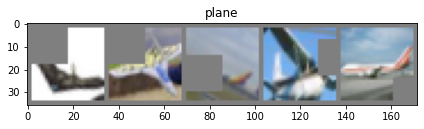

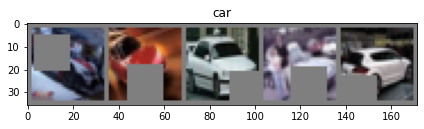

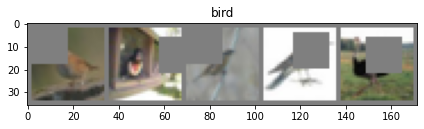

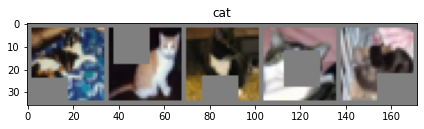

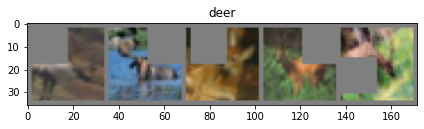

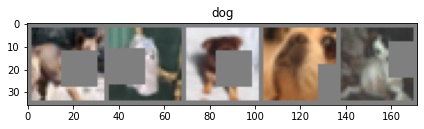

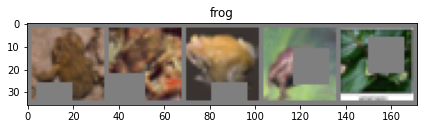

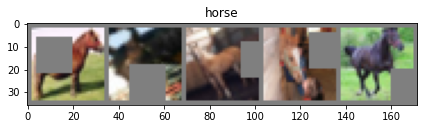

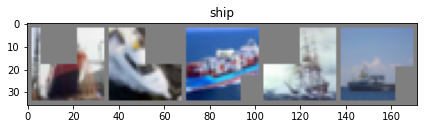

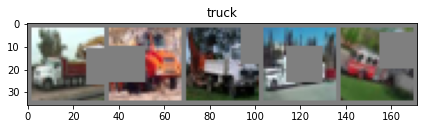

In [7]:
show_images.show_random_images(trainloader, classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
    scheduler.step()
    train_test.test(resnet, device, criterion, testloader)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.303316354751587 Batch_id=390 Accuracy=43.40: 100%|██████████| 391/391 [00:57<00:00,  6.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5469/10000 (54.69%)

EPOCH: 2


Loss=1.455922245979309 Batch_id=390 Accuracy=58.17: 100%|██████████| 391/391 [00:59<00:00,  6.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 6488/10000 (64.88%)

EPOCH: 3


Loss=0.9050432443618774 Batch_id=390 Accuracy=65.08: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6899/10000 (68.99%)

EPOCH: 4


Loss=0.7159186005592346 Batch_id=390 Accuracy=68.83: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7630/10000 (76.30%)

EPOCH: 5


Loss=0.7755211591720581 Batch_id=390 Accuracy=70.89: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7055/10000 (70.55%)

EPOCH: 6


Loss=0.6634169816970825 Batch_id=390 Accuracy=72.10: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6788/10000 (67.88%)

EPOCH: 7


Loss=0.7982218265533447 Batch_id=390 Accuracy=73.47: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7920/10000 (79.20%)

EPOCH: 8


Loss=0.8638846278190613 Batch_id=390 Accuracy=74.72: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7912/10000 (79.12%)

EPOCH: 9


Loss=0.695173442363739 Batch_id=390 Accuracy=80.74: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8726/10000 (87.26%)

EPOCH: 10


Loss=0.5420932173728943 Batch_id=390 Accuracy=82.25: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8801/10000 (88.01%)

EPOCH: 11


Loss=0.5134989619255066 Batch_id=390 Accuracy=83.40: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8824/10000 (88.24%)

EPOCH: 12


Loss=0.5115736126899719 Batch_id=390 Accuracy=84.15: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8788/10000 (87.88%)

EPOCH: 13


Loss=0.4514732360839844 Batch_id=390 Accuracy=84.50: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8884/10000 (88.84%)

EPOCH: 14


Loss=0.6019191145896912 Batch_id=390 Accuracy=85.02: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8887/10000 (88.87%)

EPOCH: 15


Loss=0.32103580236434937 Batch_id=390 Accuracy=85.47: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8841/10000 (88.41%)

EPOCH: 16


Loss=0.35880619287490845 Batch_id=390 Accuracy=85.69: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8816/10000 (88.16%)

EPOCH: 17


Loss=0.347010999917984 Batch_id=390 Accuracy=87.15: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9016/10000 (90.16%)

EPOCH: 18


Loss=0.37981611490249634 Batch_id=390 Accuracy=87.52: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9039/10000 (90.39%)

EPOCH: 19


Loss=0.37417206168174744 Batch_id=390 Accuracy=87.74: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9019/10000 (90.19%)

EPOCH: 20


Loss=0.2867726683616638 Batch_id=390 Accuracy=87.86: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9039/10000 (90.39%)

EPOCH: 21


Loss=0.36572155356407166 Batch_id=390 Accuracy=88.07: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9046/10000 (90.46%)

EPOCH: 22


Loss=0.3830415606498718 Batch_id=390 Accuracy=87.99: 100%|██████████| 391/391 [01:04<00:00,  6.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9048/10000 (90.48%)

EPOCH: 23


Loss=0.4304225444793701 Batch_id=390 Accuracy=88.18: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9045/10000 (90.45%)

EPOCH: 24


Loss=0.35219746828079224 Batch_id=390 Accuracy=88.18: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9066/10000 (90.66%)

EPOCH: 25


Loss=0.28502053022384644 Batch_id=390 Accuracy=88.55: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9074/10000 (90.74%)

EPOCH: 26


Loss=0.36346155405044556 Batch_id=390 Accuracy=88.76: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9069/10000 (90.69%)

EPOCH: 27


Loss=0.3981141149997711 Batch_id=390 Accuracy=88.51: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9083/10000 (90.83%)

EPOCH: 28


Loss=0.2917023301124573 Batch_id=390 Accuracy=88.88: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9077/10000 (90.77%)

EPOCH: 29


Loss=0.30534040927886963 Batch_id=390 Accuracy=88.71: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9080/10000 (90.80%)

EPOCH: 30


Loss=0.4924556612968445 Batch_id=390 Accuracy=88.52: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]



Test set: Average loss: 0.0021, Accuracy: 9085/10000 (90.85%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    dog horse   car  deer
Predicted:    dog horse   car  deer


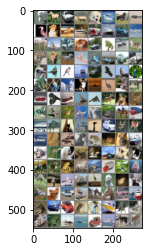

In [11]:
evaluate.show_predicted_actual(resnet, device, testloader, classes)


Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 90.850 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [13]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 91 %
Accuracy of   cat : 89 %
Accuracy of  deer : 84 %
Accuracy of   dog : 82 %
Accuracy of  frog : 92 %
Accuracy of horse : 97 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %


In [0]:
#from GradCam import GradCAM,visualize_cam

import PIL
img_name =[sys.path[-1]+'/plane.jpg',sys.path[-1]+'/car.jpg',sys.path[-1]+'/bird.jpg',sys.path[-1]+'/cat.jpg',sys.path[-1]+'/deer.jpg',sys.path[-1]+'/dog.jpg',sys.path[-1]+'/frog.jpg',sys.path[-1]+'/horse.jpg',sys.path[-1]+'/ship.jfif',sys.path[-1]+'/truck.jpg',]
#img_path = sys.path[-1]+img_name

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))
#pil_img = PIL.Image.open(img_path)
#pil_img

In [0]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)

  normed_torch_img .append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c="" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

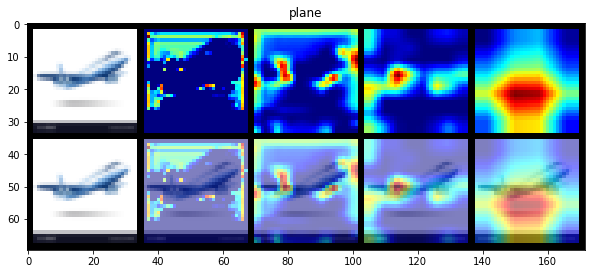

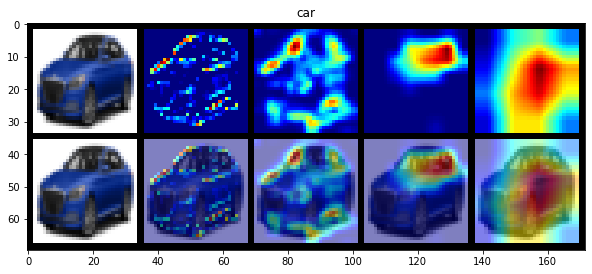

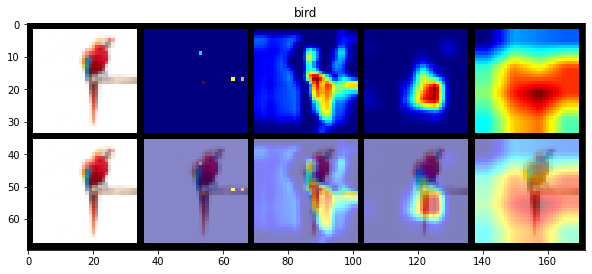

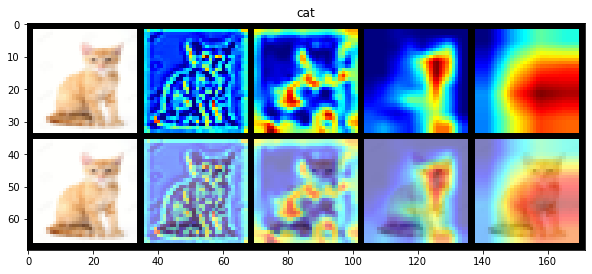

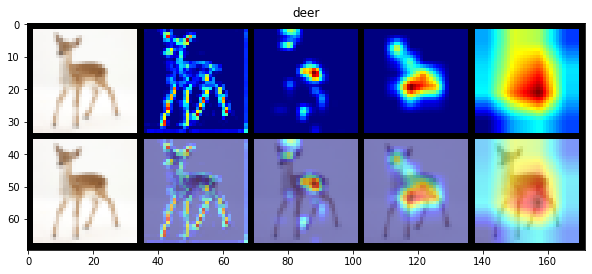

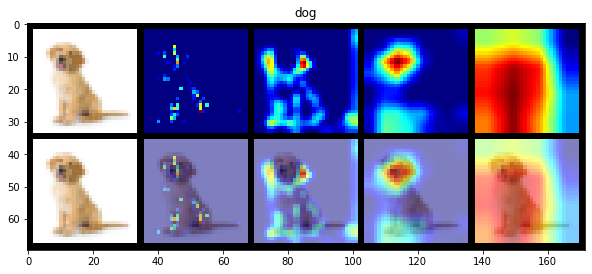

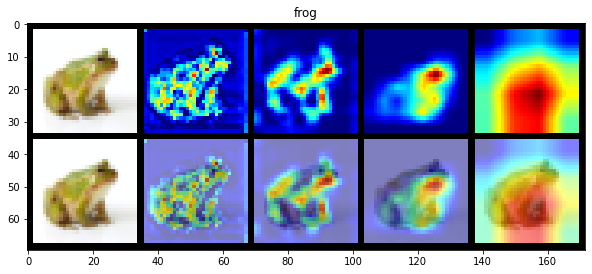

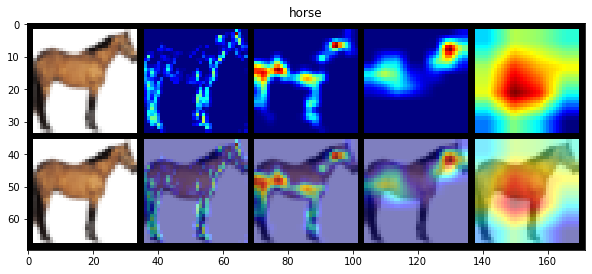

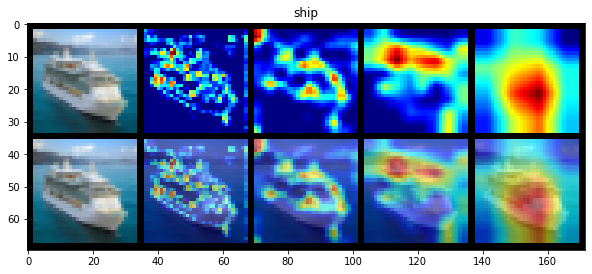

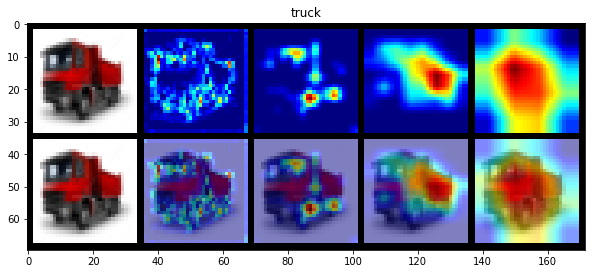

In [18]:
import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(resnet.to(device))
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2, nrow=5)
  imshow(grid_image,classes[i])